In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "../fl_sim/")

In [2]:
import os
import random
import glob
import json
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams["figure.figsize"] = (10,6)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from opts import get_args
from argparse import Namespace

from models import *
from data_funcs import *

# Utility functions
from utils.utils import top1_accuracy, \
    create_model_dir, init_metrics_meter, extend_metrics_dict, metric_to_dict
from utils.tasks import get_task_elements, get_agg, get_sampling, get_optimizer_init
from utils.logger import Logger

# Main Modules
from worker import *
from server import TorchServer
from simulator import ParallelTrainer, DistributedEvaluator

# Hyperparameters

In [3]:
args_dict = {
    "task": "linear-mixture1",
    "agg": "mean",
    "sampling": "fixed",
    "simulated_workers": 8,

    "seed": 123,
    "log_interval": 1,
    "identifier": "test",

    "comm_rounds": 50,
    "local_epochs": 1,
    "global_opt": "sgd",
    "local_opt": "sgd",
    "global_lr": 4.0,  # 1.0 for 4 workers
    "local_lr": 0.2,
    "lr_sched": "exp",
    "batch_size": 10,
    "test_batch_size": 10,

    "gpu": "0",
    "num_workers": 0,
    "loglevel": "INFO",
    "deterministic": True,
}

args = get_args(None, namespace=Namespace(**args_dict))

# Setup

In [4]:
# Logger
Logger.setup_logging("INFO", logfile="")
Logger()

# CUDA support
if torch.cuda.device_count():
    cuda_support = True
else:
    Logger.get().warning('CUDA unsupported!!')
    cuda_support = False

# Seed
if cuda_support:
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)
torch.manual_seed(args.seed)

# Loader kwargs
loader_kwargs = {}
if not args.device == 'cpu':
    loader_kwargs["num_workers"] = args.num_workers
    loader_kwargs["persistent_workers"] = args.num_workers > 0
train_loader_kwargs = {'batch_size': args.batch_size, 'shuffle': True, 'drop_last': True, **loader_kwargs}

[2023-02-16 19:34:03] (32625) {1057815708.py:9}WARNING - CUDA unsupported!!


## Task init

In [5]:
# Task inits
init_model, loss_func, is_rnn, test_batch_size, train_datasets, test_dataset = \
    get_task_elements(args.task, args.test_batch_size, args.data_path)

### DataLoaders, Models and Optimizers

In [6]:
test_loader = DataLoader(test_dataset, test_batch_size, shuffle=False, **loader_kwargs)
train_loader_s = [DataLoader(dataset, args.batch_size, shuffle=True, **loader_kwargs) for
                  dataset in train_datasets]

def count_params(module):
    return sum(p.numel() for p in module.parameters())

global_model = init_model().to(args.device)
Logger.get().info(f"Global model has {count_params(global_model)} parameters.")
local_model_s = [init_model().to(args.device) for _ in range(args.simulated_workers)]

local_opt_init = get_optimizer_init(args.local_opt, args.local_lr)
global_opt_init = get_optimizer_init(args.global_opt, args.global_lr)
server_opt = global_opt_init(global_model.parameters())

[2023-02-16 19:34:03] (32625) {2048266642.py:9}INFO - Global model has 2 parameters.


### Aggregator, Sampler, Metrics

In [7]:
agg = get_agg(args.aggregation)
client_sampler = get_sampling(args.sampling, args.comm_rounds, args.simulated_workers,
                              len(train_loader_s), args.seed)
if 'fedgan' in args.task:
    metrics = {k: (lambda _: 0.0) for k in TorchWorkerFedGAN.METRICS}
elif 'gan' in args.task:
    metrics = {k: (lambda _: 0.0) for k in TorchWorkerGAN.METRICS}
else:
    metrics = {}
Logger.get().debug(f"metrics: {list(metrics.keys())}")

[2023-02-16 19:34:03] (32625) {base.py:11}INFO - Init aggregator: Mean
[2023-02-16 19:34:03] (32625) {base.py:9}INFO - Init sampler: Fixed Sampler


### Server, Trainer, and Workers

In [8]:
server = TorchServer(
    global_model=global_model,
    optimizer=server_opt
)
trainer = ParallelTrainer(
    server=server,
    aggregator=agg,
    client_sampler=client_sampler,
    datasets=train_datasets,
    data_loader_kwargs=train_loader_kwargs,
    log_interval=args.log_interval,
    metrics=metrics,
    device=args.device,
    lr_sched=args.lr_sched,
    aggregate_optim=args.aggregate_optim,
)

for worker_id, w_model in enumerate(local_model_s):
    worker = initialize_worker(
        worker_id=worker_id,
        model=w_model,
        optimizer_init=local_opt_init,
        loss_func=loss_func,
        is_rnn=is_rnn,
        device=args.device,
        server=server,
        log_interval=args.log_interval,
        private_modules=['weight' if 'mixture3' in args.task else 'bias']
    )
    trainer.add_worker(worker)

[2023-02-16 19:34:03] (32625) {simulator.py:125}INFO - => Add worker TorchWorkerPartial [0]
[2023-02-16 19:34:03] (32625) {simulator.py:125}INFO - => Add worker TorchWorkerPartial [1]
[2023-02-16 19:34:03] (32625) {simulator.py:125}INFO - => Add worker TorchWorkerPartial [2]
[2023-02-16 19:34:03] (32625) {simulator.py:125}INFO - => Add worker TorchWorkerPartial [3]
[2023-02-16 19:34:03] (32625) {simulator.py:125}INFO - => Add worker TorchWorkerPartial [4]
[2023-02-16 19:34:03] (32625) {simulator.py:125}INFO - => Add worker TorchWorkerPartial [5]
[2023-02-16 19:34:03] (32625) {simulator.py:125}INFO - => Add worker TorchWorkerPartial [6]
[2023-02-16 19:34:03] (32625) {simulator.py:125}INFO - => Add worker TorchWorkerPartial [7]


# Visualize Data

In [9]:
trainer.set_data_loaders(1)

In [10]:
dicts = []
for worker in trainer.workers:
    for data, target in worker.data_loader:
        for x, y in zip(data.tolist(), target.tolist()):
            dicts.append({'worker_id': worker.worker_id, 'x': x[0], 'y': y[0]})
df = pd.DataFrame(dicts)
df

,worker_id,x,y
0,0,1.910005,-1.124004
1,0,1.843241,-1.194736
2,0,1.263296,-1.747019
3,0,1.655682,-1.344302
4,0,1.460607,-1.445171
...,...,...,...
395,7,-1.519668,1.497469
396,7,-1.852612,1.125577
397,7,-1.528653,1.421961
398,7,-1.524251,1.494675


<AxesSubplot:xlabel='x', ylabel='y'>

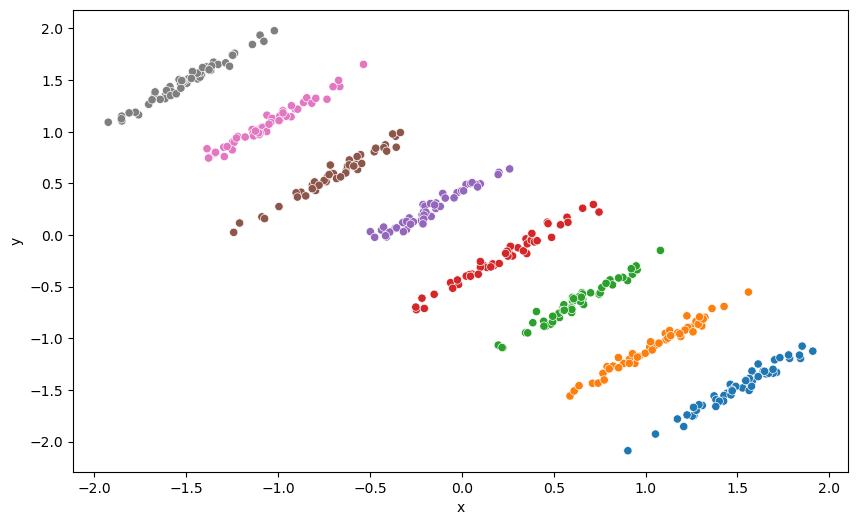

In [11]:
sns.scatterplot(data=df, x='x', y='y', hue='worker_id', palette='tab10', legend=False)

# Train

## Train partially-federated model

In [12]:
test_evaluator = DistributedEvaluator(
    model=global_model,
    is_rnn=is_rnn,
    data_loader=test_loader,
    loss_func=loss_func,
    device=args.device,
    metrics=metrics,
    log_interval=args.log_interval,
    log_identifier_type='Test',
)

In [13]:
full_metrics = init_metrics_meter(metrics)
model_dir = create_model_dir(args)
# create model directory
os.makedirs(model_dir, exist_ok=True)
test_metric = test_evaluator.evaluate(0)
extend_metrics_dict(
    full_metrics, metric_to_dict(test_metric, metrics, 0, 'test'))

# prepare progress snapshots
trainer.set_data_loaders(1)
for worker in trainer.workers:
    worker.progress_frames = []
    x, y = next(iter(worker.data_loader))
    worker.fixed_x = x.to(worker.device)
    worker.fixed_y = y.to(worker.device)

for comm_round in range(1, args.comm_rounds + 1):
    Logger.get().info(f"Communication round {comm_round}/{args.comm_rounds}")
    train_metric = trainer.train(comm_round)
    # add progress snapshots
    for worker in trainer.workers:
        y = worker.model(worker.fixed_x)
        worker.progress_frames.append(y.detach())
    extend_metrics_dict(
        full_metrics, metric_to_dict(train_metric, metrics, comm_round, 'train'))
    if comm_round % args.eval_every == 0 or comm_round == args.comm_rounds:
        test_metric = test_evaluator.evaluate(comm_round)
        extend_metrics_dict(
            full_metrics, metric_to_dict(test_metric, metrics, comm_round, 'test'))
#  store the run
with open(os.path.join(
        model_dir, 'full_metrics.json'), 'w') as f:
    json.dump(full_metrics, f, indent=4)

[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 1/40 | loss = 0.1250; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 2/40 | loss = 0.1641; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 3/40 | loss = 0.1299; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 4/40 | loss = 0.1162; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 5/40 | loss = 0.1252; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 6/40 | loss = 0.1238; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 7/40 | loss = 0.1437; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 8/40 | loss = 0.1370; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 9/40 | loss = 0.1384; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 10/40 | loss = 0.1397; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 11/40 | loss = 0.1403; 
[2023-02-16 19:34:03] (32625) {simulator.py:208}INFO - Test | 1

## Visualize

In [32]:
from matplotlib import animation
from IPython.display import HTML

plt.ioff()
fig, ax = plt.subplots()

def animate(progress_idx):
    ax.cla()
    dicts = []
    for worker in trainer.workers:
        frame = worker.progress_frames[progress_idx]
        for x, y, y_pred in zip(worker.fixed_x.tolist(), worker.fixed_y.tolist(), frame.tolist()):
            dicts.append({'worker_id': worker.worker_id, 'type': "real", 'x': x[0], 'y': y[0]})
            dicts.append({'worker_id': worker.worker_id, 'type': "fixed_x", 'x': x[0], 'y': y_pred[0]})
    df = pd.DataFrame(dicts)
    # sns.scatterplot(x='x', y='y', hue='worker_id', style='type', palette='tab10', data=df, ax=ax, animated=True)
    sns.scatterplot(x='x', y='y', hue='worker_id', palette='tab10', data=df[df['type'] == "real"], ax=ax, animated=True, legend=False)
    sns.lineplot(x='x', y='y', hue='worker_id', palette='tab10', data=df[df['type'] == "fixed_x"], ax=ax, animated=True, legend=False)

ani = animation.FuncAnimation(fig, animate, frames=len(trainer.workers[0].progress_frames), interval=100)
# ani.save("simpson_paradox_fedregression.mp4")
HTML(ani.to_html5_video())

[2023-02-17 10:37:39] (32625) {animation.py:1050}INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2023-02-17 10:37:39] (32625) {animation.py:328}INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x600 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y simpson_paradox_fedregression.mp4


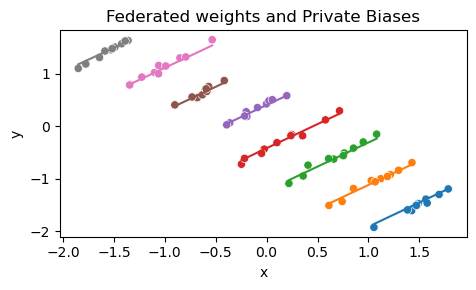

In [47]:
fig = plt.figure(figsize=(5,3))

dicts = []
for worker in trainer.workers:
    frame = worker.progress_frames[-1]
    for x, y, y_pred in zip(worker.fixed_x.tolist(), worker.fixed_y.tolist(), frame.tolist()):
        dicts.append({'worker_id': worker.worker_id, 'type': "real", 'x': x[0], 'y': y[0]})
        dicts.append({'worker_id': worker.worker_id, 'type': "fixed_x", 'x': x[0], 'y': y_pred[0]})
df = pd.DataFrame(dicts)
sns.scatterplot(x='x', y='y', hue='worker_id', palette='tab10', data=df[df['type'] == "real"], legend=False)
sns.lineplot(x='x', y='y', hue='worker_id', palette='tab10', data=df[df['type'] == "fixed_x"], legend=False)
plt.title("Federated weights and Private Biases")
plt.tight_layout()
plt.savefig("simpson_paradox_fedregression.pdf")
plt.show()

## Train a linear classifier on all data

In [22]:
linear_model = nn.Linear(1, 1)
linear_optim = torch.optim.Adam(linear_model.parameters(), lr=0.1)
alldata_loader = DataLoader(test_dataset, args.batch_size*4, shuffle=True, **loader_kwargs)

In [23]:
linear_progress_frames = []
x, y = next(iter(alldata_loader))
linear_fixed_x, linear_fixed_y = x.to(args.device), y.to(args.device)

for e in range(args.comm_rounds):
    loss_mean = 0.
    for i, (data, target) in enumerate(alldata_loader):
        data, target = data.to(args.device), target.to(args.device)
        batch_size = data.shape[0]
        linear_optim.zero_grad()
        output = linear_model(data)
        loss = loss_func(output, target)
        loss.backward()
        linear_optim.step()
        loss_mean += loss.item() / len(alldata_loader)

    print(loss_mean)
    y = linear_model(linear_fixed_x)
    linear_progress_frames.append(y.detach())

linear_mse = loss.item()

0.24006228148937225
0.20184089839458466
0.19150727391242983
0.18994962796568868
0.18912838399410248
0.18474136739969255
0.18380270153284073
0.18446296155452727
0.1803038254380226
0.18134823441505435
0.18311881721019743
0.18406795859336855
0.1828628584742546
0.1842046469449997
0.18304609209299086
0.1826089359819889
0.18420877382159231
0.18324331194162372
0.18219542950391768
0.17916562855243684
0.18517103269696236
0.1808949023485184
0.18306987658143042
0.18394317999482157
0.188259656727314
0.18193000480532642
0.1831439882516861
0.18045624271035193
0.1805746540427208
0.1809545859694481
0.18206479102373124
0.18595266044139863
0.18417822271585463
0.1842657074332237
0.182031811773777
0.18499785736203198
0.18237262070178983
0.18070545867085458
0.18268442451953887
0.18113679885864256
0.18190670311450954
0.18642211109399795
0.18770300149917601
0.18279824331402778
0.18802454918622968
0.1814034581184387
0.18868277147412302
0.1874359890818596
0.18948833048343658
0.1867571085691452


In [33]:
from matplotlib import animation
from IPython.display import HTML

plt.ioff()
fig, ax = plt.subplots()

def animate(progress_idx):
    ax.cla()
    dicts = []
    frame = linear_progress_frames[progress_idx]
    for x, y, y_pred in zip(linear_fixed_x.tolist(), linear_fixed_y.tolist(), frame.tolist()):
        dicts.append({'type': "real", 'x': x[0], 'y': y[0]})
        dicts.append({'type': "fixed_x", 'x': x[0], 'y': y_pred[0]})
    df = pd.DataFrame(dicts)
    sns.scatterplot(x='x', y='y', data=df[df['type'] == "real"], ax=ax, animated=True)
    sns.lineplot(x='x', y='y', data=df[df['type'] == "fixed_x"], ax=ax, animated=True)

ani = animation.FuncAnimation(fig, animate, frames=len(linear_progress_frames), interval=100)
# ani.save("simpson_paradox_simpleregression.mp4")
HTML(ani.to_html5_video())

[2023-02-17 10:38:08] (32625) {animation.py:1050}INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2023-02-17 10:38:08] (32625) {animation.py:328}INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x600 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y simpson_paradox_simpleregression.mp4


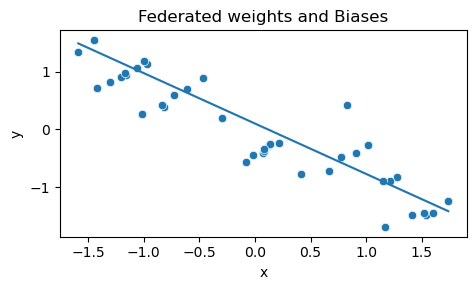

In [46]:
fig = plt.figure(figsize=(5,3))

dicts = []
for worker in trainer.workers:
    frame = linear_progress_frames[-1]
    for x, y, y_pred in zip(linear_fixed_x.tolist(), linear_fixed_y.tolist(), frame.tolist()):
        dicts.append({'worker_id': worker.worker_id, 'type': "real", 'x': x[0], 'y': y[0]})
        dicts.append({'worker_id': worker.worker_id, 'type': "fixed_x", 'x': x[0], 'y': y_pred[0]})
df = pd.DataFrame(dicts)
sns.scatterplot(x='x', y='y', data=df[df['type'] == "real"], legend=False)
sns.lineplot(x='x', y='y', data=df[df['type'] == "fixed_x"], legend=False)
plt.title("Federated weights and Biases")
plt.tight_layout()
plt.savefig("simpson_paradox_simpleregression.pdf")
plt.show()

## Train a routing classifier

In [29]:
alldata_loader = DataLoader(test_dataset, args.batch_size, shuffle=True, **loader_kwargs)
router = nn.Linear(2, len(trainer.workers))
torch.nn.init.constant_(router.weight.data, 1 / len(trainer.workers))
router_optim = torch.optim.Adam(router.parameters(), lr=0.1)

for e in range(args.comm_rounds):
    loss_mean = 0.
    for i, (data, target) in enumerate(alldata_loader):
        data, target = data.to(args.device), target.to(args.device)
        batch_size = data.shape[0]
        router_optim.zero_grad()

        # route model then run regression inside model
        router_probs = F.softmax(router(torch.cat([data, target], dim=1)), dim=1)
        with torch.no_grad():
            outputs = torch.stack([worker.model(data) for worker in trainer.workers], dim=1)
        output = torch.sum(router_probs.unsqueeze(-1) * outputs, dim=1)

        loss = loss_func(output, target)
        loss.backward()
        router_optim.step()

        loss_mean += loss.item() / len(alldata_loader)
    print(f"E{e+1:02d}: loss = {loss_mean}")

routing_mse = loss_mean

E01: loss = 0.3855285782366992
E02: loss = 0.04737822022289037
E03: loss = 0.018313259468413886
E04: loss = 0.016819135250989346
E05: loss = 0.016865742625668634
E06: loss = 0.017165550799109044
E07: loss = 0.017568982997909186
E08: loss = 0.01648696372285485
E09: loss = 0.0160809505963698
E10: loss = 0.0179647148004733
E11: loss = 0.01845117311459035
E12: loss = 0.016310101223643868
E13: loss = 0.01568606169894338
E14: loss = 0.016943427524529396
E15: loss = 0.01574603690532967
E16: loss = 0.016039495228324086
E17: loss = 0.014786727691534902
E18: loss = 0.015376129024662078
E19: loss = 0.014505891315639017
E20: loss = 0.013839472946710882
E21: loss = 0.012685895594768225
E22: loss = 0.01242288138018921
E23: loss = 0.01244816113321576
E24: loss = 0.010538346905377693
E25: loss = 0.00991565624717623
E26: loss = 0.009151770250173285
E27: loss = 0.008439057599753143
E28: loss = 0.008197712179389782
E29: loss = 0.007326450879918412
E30: loss = 0.007017213126528075
E31: loss = 0.0066649488

In [30]:
print(f"Simple Classifier MSE = {linear_mse}")
print(f"Mxiture-of-Classifiers MSE = {routing_mse}")

Simple Classifier MSE = 0.13682714104652405
Mxiture-of-Classifiers MSE = 0.0027715332951629527
